In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Mild Demented        8960
Moderate Demented    6464
Non Demented         3200
Very MildDemented    2240
Name: count, dtype: int64


In [ ]:
Alzheimer_df.shape

In [4]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

In [5]:
# image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
image_gen = ImageDataGenerator(horizontal_flip=True,)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(150,150),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(150,150),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(150,150),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 16691 validated image filenames belonging to 4 classes.
Found 6260 validated image filenames belonging to 4 classes.
Found 4173 validated image filenames belonging to 4 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
show_knee_images(train)

In [10]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten , BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
import tensorflow as tf
!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback

In [11]:

from tensorflow.keras import regularizers


model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
#     keras.layers.Dense(1024, activation='relu'),
#     keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

# def my_model():
#     model = Sequential()
#     input_shape = (244,244,1)
#     model.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
#     model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(256, (5, 5),activation='relu',padding='same'))
#     model.add(Conv2D(256, (5, 5),activation='relu',padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
#     model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(4))
#     model.add(Activation('softmax'))
    
#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
#     # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
#     #model.summary()
    
#     return model
# model=my_model()
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                        

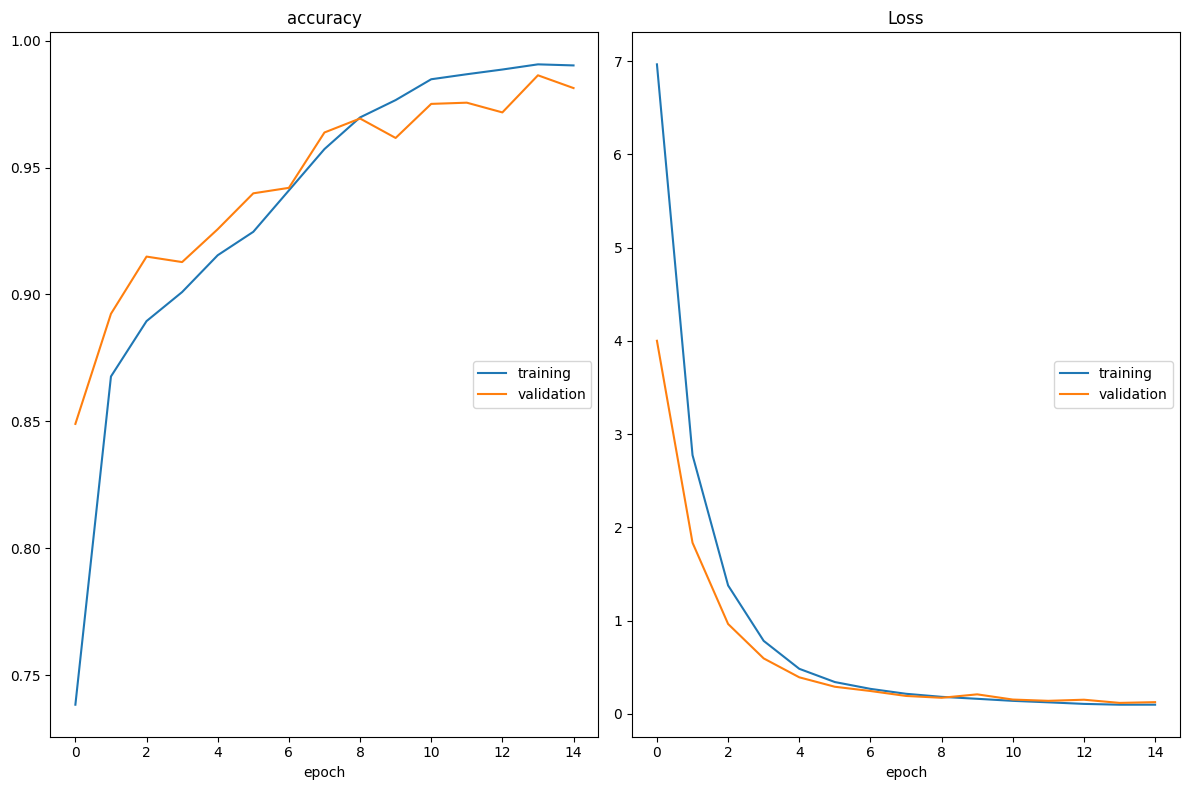

accuracy
	training         	 (min:    0.738, max:    0.991, cur:    0.990)
	validation       	 (min:    0.849, max:    0.986, cur:    0.981)
Loss
	training         	 (min:    0.099, max:    6.965, cur:    0.100)
	validation       	 (min:    0.119, max:    4.001, cur:    0.127)

Epoch 15: accuracy did not improve from 0.99065
522/522 [==============================] - 53s 101ms/step - loss: 0.0995 - accuracy: 0.9902 - val_loss: 0.1265 - val_accuracy: 0.9813 - lr: 1.0000e-04


In [12]:
# history = model.fit(train, epochs=15, validation_data=val, validation_freq=1)
epochs = 15

checkpoint = ModelCheckpoint("model.weights.h5",monitor="accuracy",save_best_only = True,
                             save_weights_only = True,
                             mode = 'auto',
                             verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor="loss",factor=0.1,patience=2,min_lr=0.00001,mode = 'auto')

callbacks = [PlotLossesCallback(),checkpoint,reduce_lr]

history = model.fit(
    train,
    epochs = epochs,
    validation_data=val,
    validation_freq=1,
    callbacks = callbacks
)

In [ ]:
# model.evaluate(test, verbose=1)
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# lmodel.save("Model_binary.h5")
model_json = model.to_json()
with open("model_json.json",'w') as json_file:
    json_file.write(model_json)
model.save("model_json.keras")

In [1]:
from keras.models import model_from_json
json_file = open("/kaggle/input/mri-images/tensorflow2/default/1/model_json.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("/kaggle/input/mri-images/tensorflow2/default/1/model_json.keras")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

196/196 [==============================] - 47s 228ms/step


In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       1.00      0.99      0.99      2715
Moderate Demented       0.99      1.00      0.99      1955
     Non Demented       0.85      0.75      0.79       962
Very MildDemented       0.67      0.79      0.73       628

         accuracy                           0.94      6260
        macro avg       0.88      0.88      0.88      6260
     weighted avg       0.94      0.94      0.94      6260

Accuracy of the Model: 93.5%


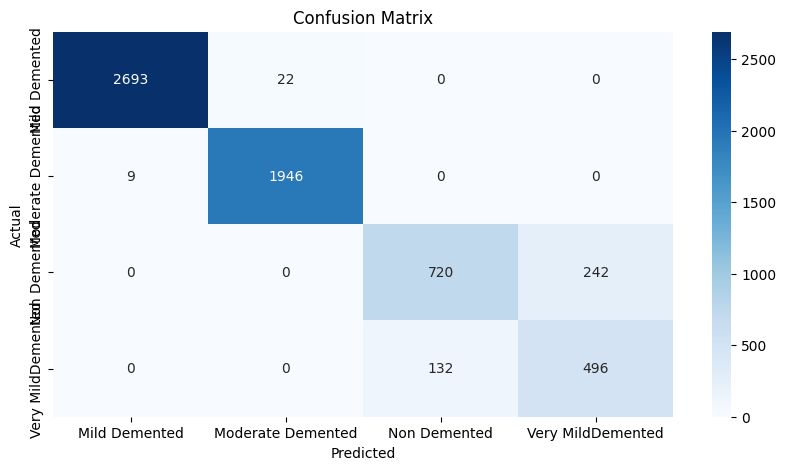

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()